In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from math import sqrt, pi
from PIL import Image as im
from PIL import ImageEnhance as ie
from segysak.segy import (
    segy_loader,
    get_segy_texthead,
    segy_header_scan,
    segy_header_scrape,
    well_known_byte_locs,
)
import glob
import pandas as pd
from scipy.interpolate import NearestNDInterpolator
import pywt
import xarray as xr
from tqdm import tqdm

In [2]:
freqs = [15, 20, 25] #Список частот для разложения

In [3]:
filepath = "stack_astack_soft_crop.sgy"
seismic = segy_loader(filepath, **well_known_byte_locs('petrel_3d'))
scan = segy_header_scan("stack_astack_soft_crop.sgy")
hors_path = glob.glob(r"?_*")
hors = []
for file in hors_path:
    hor1 = pd.read_csv(file, header=None, sep=r'\t+|:|\s+', engine='python', names=["dummy1", "dummy2", "dummy3", "INLINE", "dummy4", "dummy5", "dummy6", "XLINE", "CDP_X", "CDP_Y", "t"])
    hor1 = hor1.drop(hor1.filter(regex='dummy*').columns, axis=1)
    hors.append(hor1)
hors

  0%|          | 0.00/11.9k [00:00<?, ? traces/s]

Loading as 3D
Fast direction is TRACE_SEQUENCE_FILE


Converting SEGY:   0%|          | 0.00/11.9k [00:00<?, ? traces/s]

C:\Users\Andrey\miniconda3\Lib\site-packages\segysak\segy\_segy_loader.py:262: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  shape = [ds.dims[d] for d in dims]


  0%|          | 0.00/1.00k [00:00<?, ? traces/s]

[       INLINE  XLINE         CDP_X         CDP_Y          t
 0           1     43  540193.35293  7.676809e+06  375.67566
 1           1     44  540195.58752  7.676834e+06  373.71497
 2           1     45  540197.82212  7.676859e+06  371.55377
 3           1     46  540200.05671  7.676884e+06  369.57855
 4           1     47  540202.29131  7.676908e+06  368.30740
 ...       ...    ...           ...           ...        ...
 10978      84    100  542388.31370  7.678043e+06  272.90039
 10979      84    101  542390.54829  7.678068e+06  271.97736
 10980      84    111  542412.89424  7.678317e+06  259.93436
 10981      84    112  542415.12883  7.678342e+06  259.27417
 10982      84    113  542417.36343  7.678367e+06  258.95502
 
 [10983 rows x 5 columns],
        INLINE  XLINE         CDP_X         CDP_Y          t
 0           1     43  540193.35293  7.676809e+06  548.14282
 1           1     44  540195.58752  7.676834e+06  547.31665
 2           1     45  540197.82212  7.676859e+06  546.6

In [4]:
meshes = xr.broadcast(seismic.cdp_x, seismic.cdp_y)
meshes_layout = xr.broadcast(seismic.iline, seismic.xline)

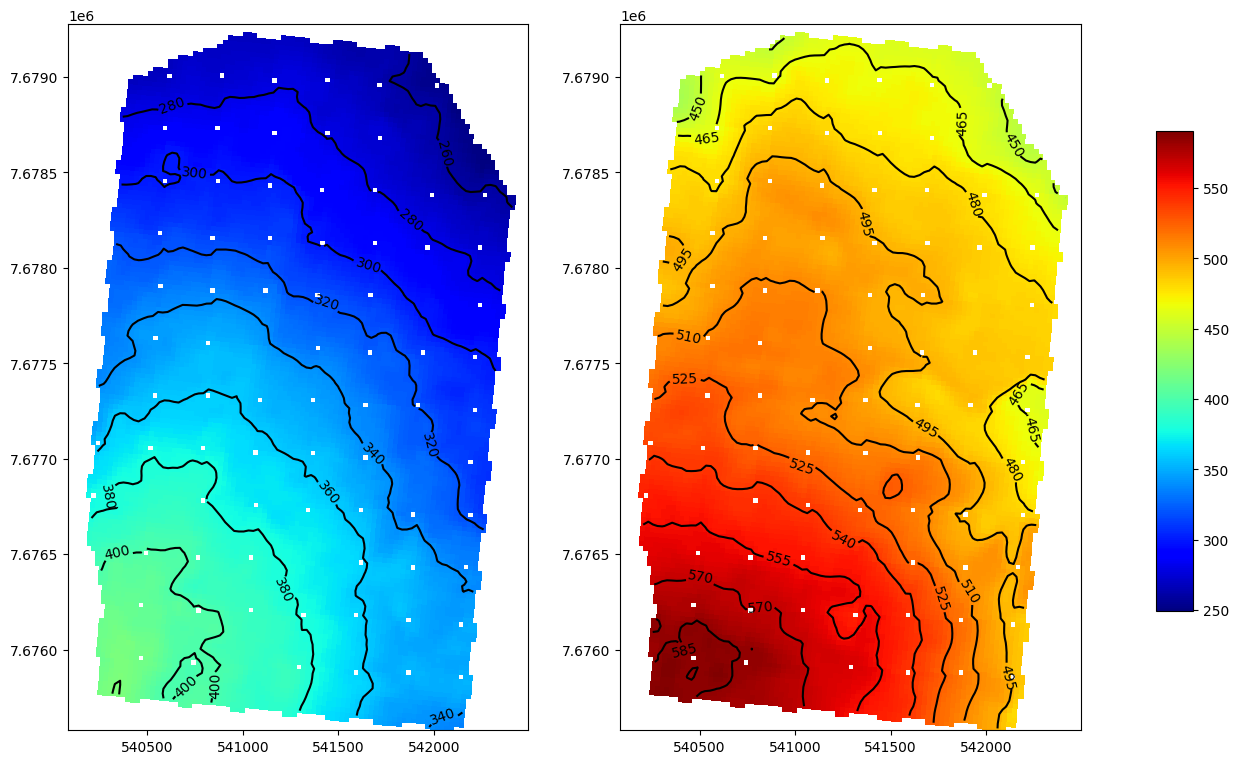

In [5]:
CDP_XX, CDP_YY = meshes
ILINE, XLINE = meshes_layout
mask = np.zeros_like(ILINE.data.ravel(), dtype='bool')
for i, (il, xl) in enumerate(zip(ILINE.data.ravel(), XLINE.data.ravel())):
    if ((hors[0]['INLINE'] == il) & (hors[0]['XLINE'] == xl)).any():
        mask[i] = True
mask = np.logical_not(np.reshape(mask, CDP_XX.shape))

interps = [NearestNDInterpolator(list(zip(hor["CDP_X"].values, hor["CDP_Y"].values)), hor["t"].values) for hor in hors]
# TWTs = [np.ma.masked_array(interp(CDP_XX, CDP_YY), mask=mask) for interp in interps]
TWTs = [interp(CDP_XX, CDP_YY) for interp in interps]

fig, axs = plt.subplots(1, 2, figsize=(15, 12))
for i, ax in enumerate(axs):
    buff = np.ma.masked_array(TWTs[i], mask=mask)
    im_h = ax.pcolormesh(CDP_XX, CDP_YY, buff, shading='auto', vmin=np.nanmin(np.array(TWTs)), vmax=np.nanmax(np.array(TWTs)), cmap='jet')
    cs = ax.contour(CDP_XX, CDP_YY, buff, 10, colors='k')
    ax.clabel(cs, cs.levels, inline=True, fontsize=10)
    ax.set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.025, 0.4])
fig.colorbar(im_h, cax=cbar_ax)
plt.show()

In [6]:
def f2w (f, bfreq = 500):
    return bfreq/(sqrt(2.0)*pi*f)

def norm10 (a,n=255.00):
    return n*(a - a.min())/(a.max() - a.min())

nodes = seismic.data.to_numpy()
inldim,crldim,tdim = nodes.shape

freqnum = dict(zip (freqs,range (len(freqs))))
bfreq = 1/(scan.loc["TRACE_SAMPLE_INTERVAL", "mean"]/1e6)
cwts = [pywt.cwt(data=nodes, wavelet="mexh", scales=f2w(freq,bfreq), axis=2) for freq in freqs]
mpD_r, mpD_g, mpD_b = [np.abs(signal.hilbert(cwt[0], axis=2)).squeeze() for cwt in cwts]

In [7]:
finl = int(np.floor(hors[0]["INLINE"].min()))
fcrl = int(np.floor(hors[0]["XLINE"].min()))
tmin = int(np.floor(hors[0]["t"].min()))
tinc = scan.loc["TRACE_SAMPLE_INTERVAL", "mean"]/1e3


t_f1 = np.abs(np.rint(np.floor((TWTs[0]-tmin)/tinc))).astype('int')
t_f2 = np.abs(np.rint(np.floor((TWTs[1]-tmin)/tinc))).astype('int')
t_c1 = np.abs(np.rint(np.ceil ((TWTs[0]-tmin)/tinc))).astype('int')
t_c2 = np.abs(np.rint(np.ceil ((TWTs[1]-tmin)/tinc))).astype('int')
td1 = np.abs((TWTs[0]-tmin)/tinc)-t_f1
td2 = np.abs((TWTs[1]-tmin)/tinc)-t_f2

In [8]:
zsl = np.zeros((inldim, crldim, len(freqs)), dtype=np.float32)

prop = 100 #Количество пропорциональных срезов
pr = [i*0.01 for i in range(0,101,int(100/prop))]
# ilind, xlind = np.nonzero(1-t_f1.mask)
ilind, xlind = np.indices((inldim, crldim))
for p in tqdm(pr):
    betw  = (1-(td1*(1-p)+p*td2)) + (td1*(1-p)+p*td2)
    tfind = (t_f1*(1-p)+p*t_f2).astype('int')
    tcind = (t_c1*(1-p)+p*t_c2).astype('int')
    
    zsl[:, :, 0] =  mpD_r[ilind, xlind, tfind] * betw * mpD_r[ilind, xlind, tcind]
    zsl[:, :, 1] =  mpD_g[ilind, xlind, tfind] * betw * mpD_g[ilind, xlind, tcind]
    zsl[:, :, 2] =  mpD_b[ilind, xlind, tfind] * betw * mpD_b[ilind, xlind, tcind]
    
    zsl[ zsl == -1.] = 0
    r = norm10(np.rot90(zsl[:,:,freqnum[freqs[0]]].T))
    g = norm10(np.rot90(zsl[:,:,freqnum[freqs[1]]].T))
    b = norm10(np.rot90(zsl[:,:,freqnum[freqs[2]]].T))
    img = im.merge('RGB', (im.fromarray(np.round(r).astype(np.uint8)),im.fromarray(np.round(g).astype(np.uint8)),im.fromarray(np.round(b).astype(np.uint8))))
    # # Сохранение RGB картинки    
    enh = ie.Brightness(img)
    # for i in range(4,5):
    factor = 3
    cdata = np.array(enh.enhance(factor))
    fig, axs = plt.subplots(1, 1, figsize=(7.5, 12))
    axs.pcolormesh(CDP_XX, CDP_YY, np.flip(cdata, axis=0),
                   shading='gouraud',
                   # antialiased=True,
                  )
    axs.set_aspect('equal')
    plt.savefig('rgb_prop%03f_%d-%d-%d.png' % (p,freqs[0],freqs[1],freqs[2]))
    plt.close()

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:43<00:00,  2.31it/s]


In [9]:
import glob
from PIL import Image


def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("15_20_25.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    

if __name__ == "__main__":
    make_gif("./")

In [ ]:
rho